In [1]:
import sys
print("Python Version:", sys.version)
import statistics
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
pd.set_option('display.max_rows', 500)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set()


import datetime
import re
import string
import nltk
import sklearn
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import MWETokenizer 
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.cluster import KMeansClusterer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

    #py file in directory
from py_files.cleaner import mr_clean_and_tokenize
from py_files.vectorizer import Vectorizer_I_Hardly_Know_Her
from py_files.vectorizer import Vectorizer_I_Hardly_Know_Her_2
from py_files.timeseriesplotter_nlp import WordVec_to_TimeSeries_Plotter

pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Python Version: 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 18:42:56) 
[Clang 10.0.1 ]


## The Setup

For this Natural Language Processing project, we will be disecting the tweets of Donald J. Trump. From TheTrumpArchive, we have every tweet President Trump has ever sent, and we will be sticking to his tweets while in office.

In [2]:
#############################################################
#Data graciously taken from https://www.thetrumparchive.com/#
#############################################################
df_tweets = pd.read_csv('tweet_data/trump_tweets_raw.csv')
pd.to_datetime(df_tweets['date'])
df_tweets.sort_values('date',ascending = False, inplace = True,ignore_index = True)
df_tweets=df_tweets.rename(columns = {'date':'DateTime'})
df_tweets['DateTime'] = [datetime.datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in df_tweets["DateTime"]] 
df_tweets['Date'] = [datetime.datetime.date(d) for d in df_tweets['DateTime']]
df_tweets['Time'] = [datetime.datetime.time(d) for d in df_tweets['DateTime']]
df_tweets['hour'] = pd.DatetimeIndex(df_tweets['DateTime']).hour
df_tweets['year'] = pd.DatetimeIndex(df_tweets['DateTime']).year
df_tweets['month'] = pd.DatetimeIndex(df_tweets['DateTime']).month
df_tweets['month_year'] = pd.to_datetime(df_tweets['DateTime']).dt.to_period('M')
df_tweets['day_month_year'] = pd.to_datetime(df_tweets['DateTime']).dt.to_period('D')

#The Day trump became president
mask = (df_tweets['Date'] >= datetime.date(2017, 1, 20))
df_trump_withRetweet = df_tweets[mask]
newmask = (df_tweets['isRetweet'] == 'f')
df_trump = df_trump_withRetweet[newmask]
df_trump.reset_index(inplace = True, drop = True)
df_trump.to_csv('df_trump.csv')
len(df_trump_withRetweet)

24758

This function found in py_files/cleaner cleans the tweets and then tokenizes them. It is the first step before we put the text into a count vectorizer. 

In [3]:
tokenized_tweets = df_trump['text'].apply(mr_clean_and_tokenize)
for tokens in tokenized_tweets:
    if 'amp' in tokens:
        tokens.remove('amp')
df_trump['tokens'] = tokenized_tweets
tokenized_tweets.head()

0      [missing, military, ballots, georgia, happened]
1    [attack, radical, left, dems, republican, sena...
2    [corrected, supreme, court, united, states, al...
3    [able, render, decisions, matter, ken, starr, ...
4    [ignored, ignored, constitution, bring, counti...
Name: text, dtype: object

Now we can create a count vectorizer from the tokenized column. This function also filters out sparse words by creating a threshhold limit. Right now the function designates the limit to be 15 times. 

In [4]:
#Now we can create a count vectorizer from the tokenized column.  #
#This function also filters out sparse words                      #
###################################################################

df_vectorized = Vectorizer_I_Hardly_Know_Her(tokenized_tweets,15)
df_vectorized.head()

abc  abe  abeshinzo  able  abolish  absentee  absolute  absolutely  abuse  \
0    0    0          0     0        0         0         0           0      0   
1    0    0          0     0        0         0         0           0      0   
2    0    0          0     0        0         0         0           0      0   
3    0    0          0     1        0         0         0           0      0   
4    0    0          0     0        0         0         0           0      0   

   acceptable  ...  wsj  xi  year  years  yes  yesterday  yet  york  young  \
0           0  ...    0   0     0      0    0          0    0     0      0   
1           0  ...    0   0     0      0    0          0    0     0      0   
2           0  ...    0   0     0      0    0          0    0     0      0   
3           0  ...    0   0     0      0    0          0    0     0      0   
4           0  ...    0   0     0      0    0          0    0     0      0   

   zero  
0     0  
1     0  
2     0  
3     0  
4     0  

[5 rows x 2159 columns]

In [5]:
count = df_vectorized.sum(axis = 0).sort_values(ascending = False)
count.head(25)

people       1656
president    1278
news         1229
country      1143
big          1116
fake         1111
democrats    1108
trump         977
many          928
new           910
would         909
never         867
vote          736
much          724
border        715
today         711
time          706
want          702
even          696
years         693
good          692
amp           675
american      655
media         641
states        639
dtype: int64

Let's do some LDA on a TFIDF vectorizer.

In [6]:
#Just to keep things clean
def string_maker(tokens):
    string = ''
    for word in tokens:
        string += ' '+word+' '
    return string
df_trump['cleaned_strings'] = tokenized_tweets.apply(string_maker)

In [7]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
df_tfidf = tfidf_vectorizer.fit_transform(df_trump['cleaned_strings'])
print(df_tfidf.shape)

(15645, 2737)


In [8]:
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(df_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

In [9]:
##gives LDA visuals
# import pyLDAvis
# import pyLDAvis.sklearn
# pyLDAvis.enable_notebook()

# pyLDAvis.sklearn.prepare(lda_tfidf, df_tfidf, tfidf_vectorizer)

## Analysis

In [10]:
#Let's check out some PCA analysis that is easy to visualize
#Start with just 2 components for a 2-d graph
pca_viz = PCA(n_components=2)
pca_viz.fit(df_vectorized)
pca_viz_df = pd.DataFrame(pca_viz.transform(df_vectorized))

In [11]:
# #F or some reason this is making my computer very slow - Saved in Directory
# plt.scatter(pca_viz_df[0],pca_viz_df[1])
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('First PCA Analysis')
# plt.savefig('2components.png');

In [12]:
#Unfortunately this few components don't seem to be explaining much variance.
pca_viz.explained_variance_ratio_.sum()

0.025740713843199682

## K-means

Let's do some cluster analysis. First we are going to try to find a good ammount of principal cocmponents to use. This is a wide range below.

Text(0, 0.5, 'Explained Variance')

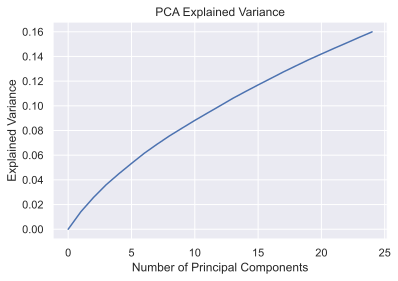

In [13]:
#Put them in a list
explained_variance = []
for i in range(25):
    pca = PCA(n_components=i)
    pca.fit(df_vectorized)
    explained_variance.append(pca.explained_variance_ratio_.sum())
plt.plot([i for i in range(25)],explained_variance)
plt.title('PCA Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')

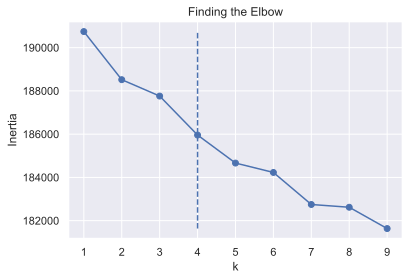

In [14]:
inertias = []
for k_ in np.arange(1, 10):
    km = KMeans(n_clusters=k_)
    km.fit(df_vectorized)
    inertias.append(km.inertia_)

plt.plot(np.arange(1, 10), inertias, marker='o')
plt.vlines(x=4, ymin=min(inertias), ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.title('Finding the Elbow')
plt.savefig('kmeanselbow.png');

In [15]:
#Lets look at the four clusters
km = KMeans(n_clusters=4)
km.fit(pca_viz_df)

KMeans(n_clusters=4)

In [16]:
# #This makes the computer run like a moron
labels = km.labels_
x = pca_viz_df[0]
y = pca_viz_df[1]
color = 'brgcmyk'
label_color = [color[l] for l in labels]
plt.scatter(x, y, c=label_color)
plt.title('2-PCA, 2 Clusters')
plt.savefig('2clusters.png');

In [17]:
df_kmeans_labels = pd.DataFrame(df_trump['text'])
df_kmeans_labels['labels'] = km.labels_
df_kmeans_labels.head()

text  labels
0  Where are the missing military ballots in Geor...       3
1  With the attack by the Radical Left Dems on th...       3
2  ....hopefully this will be corrected at the Su...       3
3  ....has been able to render decisions in a mat...       3
4  ....Legislature. They just ignored that, ignor...       3

## Gaussian Mixture Model

This is the full model.

In [18]:
gmix = GaussianMixture(n_components=4,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='random',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)
gmix.fit(df_vectorized)

GaussianMixture(init_params='random', n_components=4)

In [23]:
gmix_labels = gmix.predict(df_vectorized)

In [24]:
# #This makes the computer run like a moron
# x = pca_viz_df[0]
# y = pca_viz_df[1]
# color = 'brgcmyk'
# label_color = [color[l] for l in gmix_labels.label]
# plt.scatter(x, y, c=label_color)
# plt.title('Gaussian Mixture Model Clusters')
# plt.savefig('gmix clusters.png');

In [32]:
gmix_labels

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

### Sticking to just 20 components

In [26]:
pca_20 = PCA(n_components=20)
pca_20.fit(df_vectorized)
df_pca_20 = pd.DataFrame(pca_20.transform(df_vectorized))

How many Clusters?

In [27]:
n_components = np.arange(2, 21)
models = [GaussianMixture(n,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10).fit(df_pca_20)
          for n in n_components]

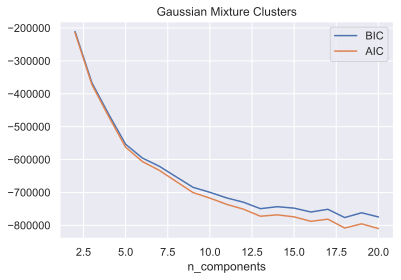

In [28]:
plt.plot(n_components, [m.bic(df_pca_20) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df_pca_20) for m in models], label='AIC')
plt.legend(loc='best')
plt.title('Gaussian Mixture Clusters')
plt.xlabel('n_components');

The model shows a slight elbow at about 7 components so we'll start with that. 

In [29]:
gmix_20 = GaussianMixture(n_components=6,
    covariance_type='full',
    tol=0.001,
    reg_covar=1e-06,
    max_iter=100,
    n_init=1,
    init_params='kmeans',
    weights_init=None,
    means_init=None,
    precisions_init=None,
    random_state=None,
    warm_start=False,
    verbose=0,
    verbose_interval=10)
gmix_20.fit(df_pca_20)

GaussianMixture(n_components=6)

In [33]:
gmix_20_labels_tweets = pd.DataFrame(gmix_20.predict(df_pca_20))
gmix_20_labels_tweets['tweet'] = df_trump['text']
gmix_20_labels_tweets.columns = ['label','tweet']

In [34]:
gmix_20_labels_tweets.head()

label                                              tweet
0      0  Where are the missing military ballots in Geor...
1      1  With the attack by the Radical Left Dems on th...
2      1  ....hopefully this will be corrected at the Su...
3      5  ....has been able to render decisions in a mat...
4      5  ....Legislature. They just ignored that, ignor...

In [35]:
gmix_20_labels_tweets.label.value_counts()

1    3355
5    3130
0    2663
3    2632
2    1994
4    1871
Name: label, dtype: int64

Looks fairly spread out! Maybe we can sum the words and see the different groupings.

In [36]:
label_counter = pd.concat([pd.DataFrame(gmix_20.predict(df_pca_20)), df_vectorized], axis =1)
label_counter=label_counter.rename(columns = {0:'label'})
group_count = label_counter.groupby(['label']).sum()
group_count

abc  abe  abeshinzo  able  abolish  absentee  absolute  absolutely  \
label                                                                       
0        2    7          2    14        0        11         5           8   
1        3   17          7    21        9         1         3          21   
2        7    2          1    26       14         7         5          10   
3       28    2          3    20        1         6         7          16   
4        0    0          1     0        0         0         0           0   
5        4    8          5    11        0         2         2           4   

       abuse  acceptable  ...  wsj  xi  year  years  yes  yesterday  yet  \
label                     ...                                              
0          2           4  ...    2   0    76      0    9         26   24   
1         18           6  ...    6  43    80    303    6         31   44   
2          6           4  ...    5  22    79    192    8         29   30   
3         11           2  ...    3   1    58    198    7         42   42   
4          0           0  ...    0   0     0      0    5          0    0   
5          5           1  ...    3   2    38      0    3         27   18   

       york  young  zero  
label                     
0        84     15     8  
1         0      9    48  
2        45      7    24  
3       129     12    40  
4         0      0     0  
5         0     11     4  

[6 rows x 2159 columns]

In [37]:
high_freq_words = pd.DataFrame()
for i in range(6):
    col_name = 'group_{}'.format(i+1)
    high_freq_words[col_name] = group_count.iloc[i].sort_values(ascending = False).index

In [38]:
high_freq_words.head(10)

group_1    group_2    group_3    group_4                   group_5  \
0       people  president        amp       news  make_america_great_again   
1          big      trump     border       fake                      maga   
2         vote  democrats     people     people                      true   
3          new      never      china      would                     happy   
4      country       many  democrats      media                harassment   
5  endorsement     united       vote    country              presidential   
6        total     states      would        big                  birthday   
7     american      years      biden       many           realdonaldtrump   
8     military      china    country  president                     agree   
9       border       even     states      never                    thanks   

           group_6  
0            today  
1            honor  
2          foxnews  
3          america  
4              see  
5          tonight  
6    foxandfriends  
7             maga  
8            enjoy  
9  congratulations

## Word2Vec

In [39]:
# Tokenize the tweets in a gensim style tokenizer
tokenized_gensim = [gensim.utils.simple_preprocess(d) for d in df_trump.text]
# Create a Gensim Dictionary.  This creates an id to word mapping for everything in our vocbulary
# It is NOT the same as the dictionary object in the Python standard library
mydict = gensim.corpora.Dictionary()
# Create a Gensim Corpus object.  This creates a list of tuples for each document.
# The first element of the tuple is the word id, the second is the number of counts
mycorpus = [mydict.doc2bow(doc, allow_update=True) for doc in tokenized_gensim]

In [40]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# sg means that we are using the Skip-gram architecture
w2v_model = gensim.models.Word2Vec(tokenized_gensim, sg=1)

Lets make a dataframe of simlar words.

In [41]:
w2v_words = ['biden', 'fake', 'immigrants', 'socialists','mob',
             'china','russia','aoc','drugs','antifa', 'left']
word_associations = pd.DataFrame()
for word in w2v_words:
    associations = w2v_model.most_similar(word ,topn=15)
    word_associations[word] = [column[0] for column in associations]
word_associations

biden            fake   immigrants   socialists            mob  \
0        sleepy      lamestream        catch         mobs     hypocrites   
1           joe       dishonest        chain       sudden         sudden   
2   scarborough        fakenews        gangs   regardless          squad   
3        hunter           cover        drugs  departments     socialists   
4        harris           false      lottery    extremist    departments   
5          eyes           media     illegals    arsonists         oppose   
6        psycho             nbc      violent        filed          blows   
7           ban         nytimes         visa   hypocrites       radicals   
8         vowed  washingtonpost       aliens        blows      arsonists   
9       sanders             cnn    unchecked     agreeing          bunch   
10       bernie       knowingly    criminals       mayors         signal   
11     digenova        networks     violence         cave  congresswomen   
12     fracking        coverage  trafficking        cross     regardless   
13       kamala             fox    crossings   committees       midterms   
14      rioters       reporting        merit       signal           trap   

           china          russia             aoc        drugs       antifa  \
0        chinese         russian           squad        gangs      looters   
1          virus        russians             mob  trafficking        filed   
2         europe           probe            hide     illegals    requested   
3          trade        colluded        unhinged        human     radicals   
4           iran  investigations  constitutional        chain        squad   
5         plague       collusion            icig   immigrants      satisfy   
6          talks         ukraine   congresswomen    criminals         band   
7   negotiations         unhappy          forgot  traffickers        thugs   
8        product        delusion          maxine         flow   protesters   
9         turkey          course            eyes      barrier    agitators   
10          nato        meddling         satisfy     stopping          mob   
11       tariffs        negative          antifa      lottery     peaceful   
12     countries      conspiracy         nervous    migration         mask   
13         nafta         blaming          sudden      closing          aoc   
14         deals         illicit          racist     lowering  politicians   

              left  
0          radical  
1          islamic  
2             wing  
3    congresswomen  
4              aoc  
5          liberal  
6           antifa  
7           unlike  
8         majority  
9          looters  
10  obstructionist  
11         seattle  
12         satisfy  
13       socialist  
14            gone

In [42]:
#analogy calculator 
#mess with later
w2v_model.most_similar(positive=['republican', 'democrat'], negative=['great'])

[('party', 0.7071056365966797),
 ('liberal', 0.6052477955818176),
 ('face', 0.5875011682510376),
 ('senators', 0.5858510732650757),
 ('republicans', 0.5800912380218506),
 ('majority', 0.5711910724639893),
 ('dem', 0.5653507709503174),
 ('run', 0.5647042393684387),
 ('opposition', 0.5544363260269165),
 ('approval', 0.5408742427825928)]

## Assigning clusters using Word2Vec and Kmeans

First we'll cluster just the words.

In [43]:
cluster_w2v_model = gensim.models.Word2Vec(tokenized_tweets, min_count=1)
vocab = list(cluster_w2v_model.wv.vocab)

In [44]:
#Lets try 5 clusters
kclusterer = KMeansClusterer(5, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(cluster_w2v_model[cluster_w2v_model.wv.vocab], assign_clusters=True)

In [45]:
vocab_groups = pd.DataFrame({'word': vocab, 'cluster': assigned_clusters})
vocab_groups.head()

word  cluster
0   missing        3
1  military        2
2   ballots        4
3   georgia        3
4  happened        4

What about the documents themselves?

In [46]:
sentence = gensim.models.doc2vec.TaggedDocument
all_content = []
j=0
for doc in df_trump['text'].values:
    all_content.append(sentence(doc,[j]))
    j+=1
print('Number of texts processed: ', j)

Number of texts processed:  15645


In [47]:
d2v_model = Doc2Vec(all_content, size = 100, window = 10, min_count = 500, workers=7, dm = 1,alpha=0.025, min_alpha=0.001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [48]:
kmeans_model = KMeans(n_clusters=8, init='k-means++', max_iter=100) 
X = kmeans_model.fit(d2v_model.docvecs.doctag_syn0)
d2v_labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(d2v_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_model.docvecs.doctag_syn0)

In [49]:
d2v_labels_tweets = pd.DataFrame(d2v_labels)
d2v_labels_tweets['tweet'] = df_trump['text']
d2v_labels_tweets['tokens'] = tokenized_tweets
d2v_labels_tweets.columns = ['label','tweet','tokens']
d2v_labels_tweets.to_csv('d2v_labels.csv')
d2v_labels_tweets.head()

label                                              tweet  \
0      7  Where are the missing military ballots in Geor...   
1      4  With the attack by the Radical Left Dems on th...   
2      1  ....hopefully this will be corrected at the Su...   
3      4  ....has been able to render decisions in a mat...   
4      1  ....Legislature. They just ignored that, ignor...   

                                              tokens  
0    [missing, military, ballots, georgia, happened]  
1  [attack, radical, left, dems, republican, sena...  
2  [corrected, supreme, court, united, states, al...  
3  [able, render, decisions, matter, ken, starr, ...  
4  [ignored, ignored, constitution, bring, counti...

In [50]:
d2v_labels_tweets['label'].value_counts()

4    3071
1    2537
2    2414
7    2077
3    1941
6    1762
0    1236
5     607
Name: label, dtype: int64

We can check most popular words for each cluster.

In [52]:
#amount of words you want
n = 10
cluster_words = pd.DataFrame()
for i in range(len(d2v_labels_tweets['label'].value_counts())):
    grouped = d2v_labels_tweets[d2v_labels_tweets['label'] == i].tokens
    vectorized = Vectorizer_I_Hardly_Know_Her_2(grouped, 20, 10000)
    count = vectorized.sum(axis = 0).sort_values(ascending = False)[0:n].index
    cluster_words['Cluster_{}'.format(i+1)]=count

In [53]:
cluster_words

Cluster_1  Cluster_2  Cluster_3 Cluster_4  Cluster_5 Cluster_6  \
0       people     people     people      vote     people   america   
1         news  president  president      jobs       news       amp   
2         fake    country        big    people  democrats     trump   
3        total      trump        new      news    country   country   
4  endorsement       many       news      fake        big      fake   
5     complete  democrats    country       big  president       big   
6         vote       news  democrats   country       fake     never   
7          big       fake      never     today       time      news   
8          new      would       fake       amp      would       new   
9          amp       much        job      maga       good      vote   

   Cluster_7  Cluster_8  
0  president     people  
1     people       news  
2  democrats  president  
3      trump    country  
4      would        big  
5        big      years  
6       fake       good  
7    country     united  
8       news     states  
9     border        new

## Time Series Analysis

In [54]:
df_trump.head()

id                                               text  \
0  1324768077939118083  Where are the missing military ballots in Geor...   
1  1324752659996397575  With the attack by the Radical Left Dems on th...   
2  1324750565092610048  ....hopefully this will be corrected at the Su...   
3  1324750568817102852  ....has been able to render decisions in a mat...   
4  1324750561514848256  ....Legislature. They just ignored that, ignor...   

  isRetweet isDeleted              device  favorites  retweets  \
0         f         f  Twitter for iPhone     319830     69266   
1         f         f  Twitter for iPhone     256141     45857   
2         f         f  Twitter for iPhone     113524     22224   
3         f         f  Twitter for iPhone     102067     19257   
4         f         f  Twitter for iPhone      53553     13287   

             DateTime        Date      Time  hour  year  month month_year  \
0 2020-11-06 17:38:17  2020-11-06  17:38:17    17  2020     11    2020-11   
1 2020-11-06 16:37:01  2020-11-06  16:37:01    16  2020     11    2020-11   
2 2020-11-06 16:28:42  2020-11-06  16:28:42    16  2020     11    2020-11   
3 2020-11-06 16:28:42  2020-11-06  16:28:42    16  2020     11    2020-11   
4 2020-11-06 16:28:41  2020-11-06  16:28:41    16  2020     11    2020-11   

  day_month_year                                             tokens  \
0     2020-11-06    [missing, military, ballots, georgia, happened]   
1     2020-11-06  [attack, radical, left, dems, republican, sena...   
2     2020-11-06  [corrected, supreme, court, united, states, al...   
3     2020-11-06  [able, render, decisions, matter, ken, starr, ...   
4     2020-11-06  [ignored, ignored, constitution, bring, counti...   

                                     cleaned_strings  
0     missing  military  ballots  georgia  happened   
1   attack  radical  left  dems  republican  sena...  
2   corrected  supreme  court  united  states  al...  
3   able  render  decisions  matter  ken  starr  ...  
4   ignored  ignored  constitution  bring  counti...

In [55]:
years = list(df_trump.year.value_counts().index)
his_tweets_by_year = df_trump.year.value_counts()
retweets_by_year = df_trump_withRetweet.year.value_counts()-his_tweets_by_year
yearly_counts = pd.DataFrame({'Tweets': his_tweets_by_year.values, 'Retweets': retweets_by_year.values},
                            index = years)
yearly_counts

Tweets  Retweets
2020    5445      5466
2019    4936      2882
2018    3104       464
2017    2160       301

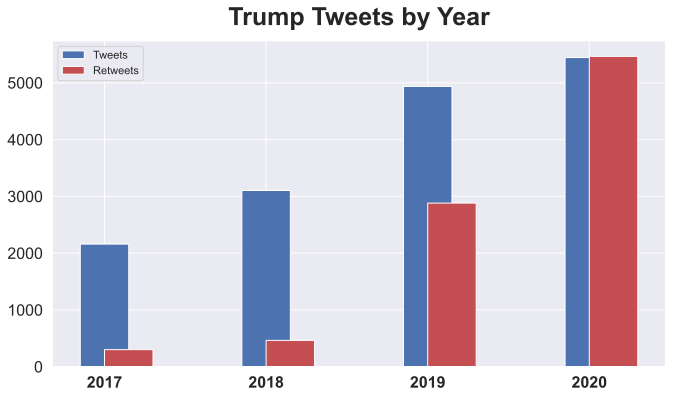

In [56]:
fig = plt.figure(figsize=(11,6))
ax = plt.subplot(111)
w = 0.3
x = list(yearly_counts.index)
y = list(his_tweets_by_year.values)
z = list(retweets_by_year.values)

ax.bar(x, y, width=w, color='b')
ax.bar(x, z, width=w, color='r', align = 'edge')
ax.set_xticks(x)
plt.xticks(fontsize=16, fontweight = 'bold')
plt.yticks(fontsize=16)
ax.legend(list(yearly_counts.columns))
plt.title('Trump Tweets by Year',fontsize=25,fontweight = 'bold', y=1.03)
plt.savefig('tweetsbyyear.png')
plt.show();

It looks like Trump tweeted more and more through his time in office. Looking at his retweets, he really went crazy! Let's look at word frequency over the years.

In [57]:
#n is the number of words we consider
n=20
word_freq_by_year = pd.DataFrame()
for year in years:
    year_words = []
    exec('df_trump_{} = df_trump[df_trump["year"] == year]'.format(year))
    exec('df_vec = Vectorizer_I_Hardly_Know_Her(df_trump_{}.tokens,15)'.format(year))
    exec('df_vec_{} = df_vec'.format(year))
    for i in range(n):
        exec('word = df_vec_{}.sum(axis = 0).sort_values(ascending = False).index[i]'.format(year))
        exec('count = df_vec_{}.sum(axis = 0).sort_values(ascending = False).values[i]'.format(year))
        year_words.append([word, count])
    word_freq_by_year['{}'.format(year)] = year_words 

In [58]:
word_freq_by_year

2020              2019              2018              2017
0        [people, 482]  [president, 596]     [people, 439]     [people, 189]
1         [biden, 456]     [people, 546]    [country, 328]       [news, 188]
2          [news, 401]  [democrats, 508]  [president, 289]       [fake, 176]
3           [joe, 384]    [country, 419]  [democrats, 277]        [big, 149]
4          [fake, 355]       [news, 377]       [many, 275]      [today, 146]
5          [vote, 349]      [trump, 374]      [trump, 273]        [tax, 138]
6           [big, 348]        [big, 357]       [news, 263]    [country, 124]
7           [new, 288]        [new, 354]        [big, 262]  [president, 113]
8     [president, 280]      [never, 352]     [border, 261]       [jobs, 109]
9         [never, 279]      [would, 350]       [fake, 235]   [american, 108]
10        [would, 276]       [fake, 345]      [trade, 196]       [many, 107]
11      [country, 272]     [border, 325]       [much, 194]     [america, 96]
12        [total, 265]       [many, 310]      [would, 190]        [time, 96]
13        [trump, 253]    [nothing, 286]       [time, 188]       [would, 93]
14    [democrats, 246]      [china, 283]      [today, 186]        [much, 90]
15          [amp, 240]       [much, 273]       [want, 186]       [media, 89]
16     [complete, 239]      [years, 270]       [good, 185]         [new, 84]
17  [endorsement, 237]       [even, 268]        [new, 184]       [years, 83]
18         [many, 236]       [good, 266]       [must, 180]   [democrats, 77]
19         [even, 229]       [time, 264]       [vote, 180]       [honor, 77]

### By Month

Lets do some analysis by month why don't we.

In [59]:
month_years_list = list(df_trump.month_year.unique())
month_years = [str(month) for month in month_years_list]

In [60]:
df_vec = df_vectorized.copy()
df_vec['datetime'] = df_trump['DateTime']
df_vec['months'] = df_trump['month_year']

In [61]:
grouped = df_vec.groupby('months').sum()
grouped_months = grouped.iloc[:46]
grouped_months

abc  abe  abeshinzo  able  abolish  absentee  absolute  absolutely  \
months                                                                        
2017-01    2    0          0     0        0         0         0           0   
2017-02    2    8          0     1        0         0         0           0   
2017-03    1    0          0     2        0         0         0           0   
2017-04    2    0          0     0        0         0         0           0   
2017-05    0    0          0     0        0         0         2           0   
2017-06    2    0          0     1        0         0         0           0   
2017-07    0    1          0     0        0         0         0           0   
2017-08    1    0          0     2        0         0         0           0   
2017-09    0    0          0     2        0         0         0           0   
2017-10    2    0          0     1        0         0         0           0   
2017-11    0    3          0     1        0         0         0           0   
2017-12    4    0          0     1        0         0         0           1   
2018-01    1    0          0     3        0         0         0           1   
2018-02    0    0          0     3        0         0         0           0   
2018-03    0    1          0     0        0         0         0           0   
2018-04    2    5          3     0        0         0         1           2   
2018-05    5    0          0     2        0         0         1           0   
2018-06    1    2          3     2        1         0         1           1   
2018-07    0    1          0     0        2         0         0           2   
2018-08    0    0          0     2        2         0         1           1   
2018-09    0    1          2     0        0         0         1           4   
2018-10    3    0          1     2        0         0         1           0   
2018-11    0    0          0     1        0         0         0           3   
2018-12    0    0          0     4        0         0         1           2   
2019-01    0    0          0     1        0         0         0           1   
2019-02    0    0          0     1        0         0         0           2   
2019-03    0    0          0     1        1         0         2           2   
2019-04    0    0          1     1        0         0         3           2   
2019-05    0    3          8     6        0         0         0           2   
2019-06    1    2          0     3        0         0         0           1   
2019-07    1    1          0     2        0         0         0           1   
2019-08    0    1          0     7        0         0         0           2   
2019-09    1    0          0     1        0         0         0           4   
2019-10    1    1          0     2        0         0         1           5   
2019-11    2    0          0     4        0         0         1           3   
2019-12    0    0          0     5        0         0         0           4   
2020-01    0    0          0     5        0         0         1           2   
2020-02    0    0          0     1        0         0         1           0   
2020-03    3    3          0     1        0         0         0           0   
2020-04    1    0          0     1        0         1         0           1   
2020-05    1    3          0     2        0         4         1           1   
2020-06    0    0          0     2        3         1         0           2   
2020-07    0    0          0     4        7         2         1           3   
2020-08    1    0          1     5        0         5         1           1   
2020-09    3    0          0     4        1        10         0           0   
2020-10    1    0          0     2        4         2         1           3   

         abuse  acceptable  ...  wsj  xi  year  years  yes  yesterday  yet  \
months                      ...                                              
2017-01      0           0  ...    0   0     0      2    0  

This data frame now has aggregated words frequency by month. We can use this to find specific months. In the file timeseriesplotter_nlp.py located in py_files, we made an awesome function that plots the words by frequency by month. We can test it out here!

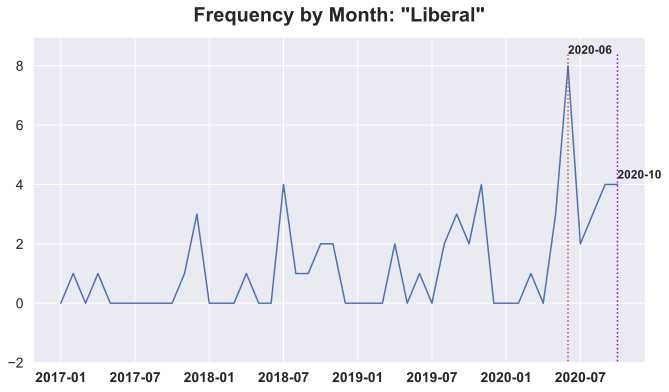

In [62]:
WordVec_to_TimeSeries_Plotter(grouped_months,'liberal',2,0,'default','default')

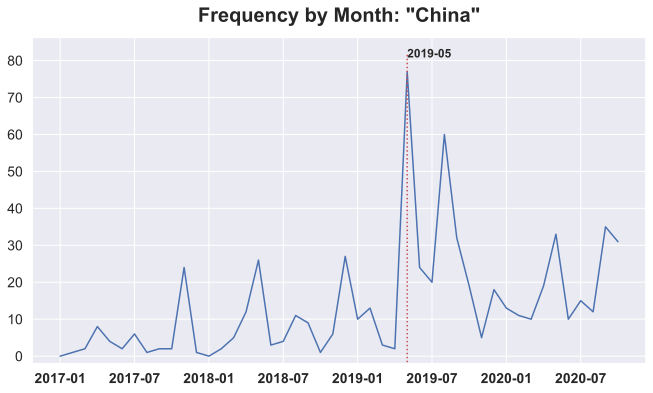

In [63]:
WordVec_to_TimeSeries_Plotter(grouped_months,'china',1,0,'default','chinabymonth')

In [64]:
month_mask = (df_vec['months']=='2019-05')
may_2019 = df_vec[month_mask]
china_mask = (may_2019['china'] != 0)
may_2019_with_china = may_2019[china_mask]

In [65]:
may_2019_china_tweets = df_trump.iloc[may_2019_with_china.index].text.reset_index(drop = True)

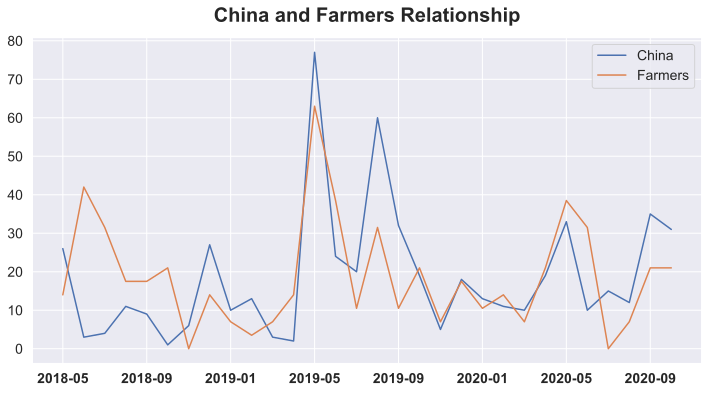

In [66]:
df = grouped_months
ts1 = df['china'][16:]
ts2 = df['farmers'][16:]
df_1 = pd.DataFrame({'Frequency': ts1.values})
df_2 = pd.DataFrame({'Frequency': ts2.values*3.5})
df_1.index = [str(date) for date in ts1.index]
df_2.index = [str(date) for date in ts2.index]

fig = plt.figure(figsize=(12,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
ax.plot(df_1['Frequency'], label = 'China')
ax.plot(df_2['Frequency'], label = 'Farmers')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14)
ax.set_title("China and Farmers Relationship",fontsize=20,fontweight = 'bold', y=1.03)
#     #Vertical lines
#     for i in range(len(most_freq_months)):
#         ax.axvline(x=x_vals[i], ymin=-1, ymax=0.95, color = colors[i], 
#                     ls = ':')
#         plt.text(x_vals[i],df_ts.loc[most_freq_months[i]].Frequency * 1.05,'{}'.format(most_freq_months[i]),rotation=theta, fontweight = 'bold')
plt.legend(loc='upper right', fontsize = 14)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.savefig('chinafarmers.png');

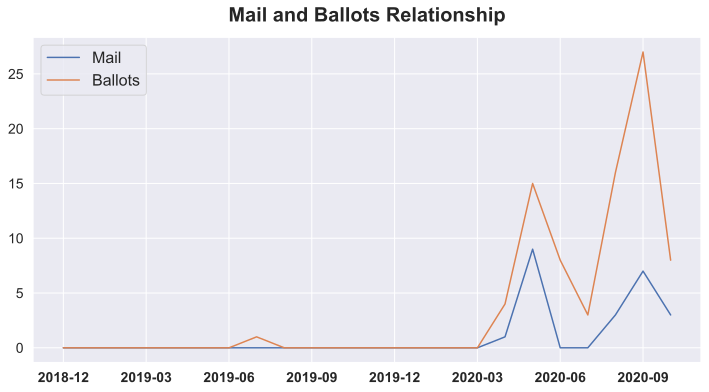

In [67]:
df = grouped_months.iloc[23:]
ts1 = df['mail']
ts2 = df['ballots']
ts3 = df['pennsylvania']
df_1 = pd.DataFrame({'Frequency': ts1.values})
df_2 = pd.DataFrame({'Frequency': ts2.values})
#df_3 = pd.DataFrame({'Frequency': ts3.values})
df_1.index = [str(date) for date in ts1.index]
df_2.index = [str(date) for date in ts2.index]
#df_3.index = [str(date) for date in ts3.index]

fig = plt.figure(figsize=(12,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
ax.plot(df_1['Frequency'], label = 'Mail')
ax.plot(df_2['Frequency'], label = 'Ballots')
#ax.plot(df_3['Frequency'], label = 'Pennsylvania')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14)
ax.set_title("Mail and Ballots Relationship",fontsize=20,fontweight = 'bold', y=1.03)
#     #Vertical lines
#     for i in range(len(most_freq_months)):
#         ax.axvline(x=x_vals[i], ymin=-1, ymax=0.95, color = colors[i], 
#                     ls = ':')
#         plt.text(x_vals[i],df_ts.loc[most_freq_months[i]].Frequency * 1.05,'{}'.format(most_freq_months[i]),rotation=theta, fontweight = 'bold')
plt.legend(loc='upper left', fontsize = 16)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.savefig('mail_fraud_ballots.png');

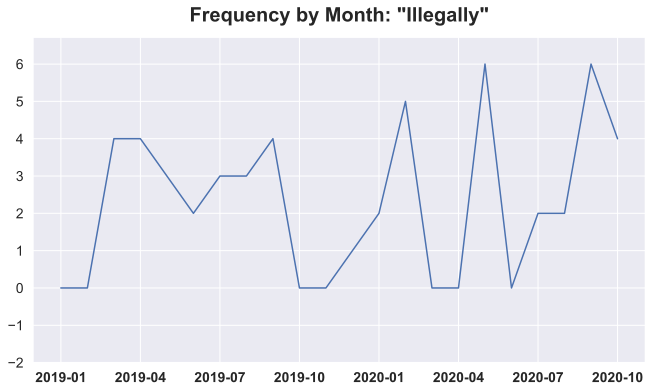

In [68]:
WordVec_to_TimeSeries_Plotter(grouped_months.iloc[24:],'illegally',0,0,'default','default')

## Sum Tweets By Hour

In [69]:
df_trump_withRetweet.head()

id                                               text  \
0  1324768077939118083  Where are the missing military ballots in Geor...   
1  1324752659996397575  With the attack by the Radical Left Dems on th...   
2  1324750565092610048  ....hopefully this will be corrected at the Su...   
3  1324750568817102852  ....has been able to render decisions in a mat...   
4  1324750561514848256  ....Legislature. They just ignored that, ignor...   

  isRetweet isDeleted              device  favorites  retweets  \
0         f         f  Twitter for iPhone     319830     69266   
1         f         f  Twitter for iPhone     256141     45857   
2         f         f  Twitter for iPhone     113524     22224   
3         f         f  Twitter for iPhone     102067     19257   
4         f         f  Twitter for iPhone      53553     13287   

             DateTime        Date      Time  hour  year  month month_year  \
0 2020-11-06 17:38:17  2020-11-06  17:38:17    17  2020     11    2020-11   
1 2020-11-06 16:37:01  2020-11-06  16:37:01    16  2020     11    2020-11   
2 2020-11-06 16:28:42  2020-11-06  16:28:42    16  2020     11    2020-11   
3 2020-11-06 16:28:42  2020-11-06  16:28:42    16  2020     11    2020-11   
4 2020-11-06 16:28:41  2020-11-06  16:28:41    16  2020     11    2020-11   

  day_month_year  
0     2020-11-06  
1     2020-11-06  
2     2020-11-06  
3     2020-11-06  
4     2020-11-06

In [70]:
len(df_trump_withRetweet.day_month_year.unique())

1379

In [71]:
retweets_only = df_trump_withRetweet[df_trump_withRetweet['isRetweet'] == 't']

In [72]:
tweets_by_hour = df_trump.hour.value_counts().sort_index(ascending = True)
retweets_by_hour = retweets_only.hour.value_counts().sort_index(ascending = True)
total_by_hour = retweets_by_hour+tweets_by_hour
hour_index = ['12:00 AM','1:00 AM', '2:00 AM', '3:00 AM','4:00 AM','5:00 AM','6:00 AM','7:00 AM',
              '8:00 AM','9:00 AM','10:00 AM','11:00 AM','12:00 PM','1:00 PM', '2:00 PM', '3:00 PM',
              '4:00 PM','5:00 PM','6:00 PM','7:00 PM','8:00 PM','9:00 PM','10:00 PM','11:00 PM']

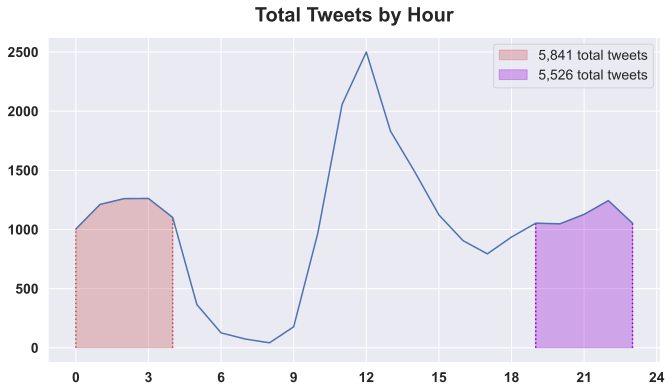

In [73]:
fig = plt.figure(figsize=(11,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
bottom = []
for i in range(24):
    bottom.append(0)
threshhold1 = (total_by_hour.index < 5)
threshhold2 = (total_by_hour.index > 18)
area1 = total_by_hour[0]+total_by_hour[1]+total_by_hour[2]+total_by_hour[3]+total_by_hour[4] # = 5841
area2 = total_by_hour[19]+total_by_hour[20]+total_by_hour[21]+total_by_hour[22]+total_by_hour[23] # = 5526

ax.plot(total_by_hour)

#section 1
plt.vlines(x=total_by_hour.index[0], ymin=0, ymax=total_by_hour.values[0], color = colors[0],ls = ':')
plt.vlines(x=total_by_hour.index[4], ymin=0, ymax=total_by_hour.values[4], color = colors[0],ls = ':')
ax.fill_between(total_by_hour.index, total_by_hour.values,bottom,
                where = threshhold1, color=colors[0], alpha=0.3, label = '5,841 total tweets')
#Section 2
plt.vlines(x=total_by_hour.index[19], ymin=0, ymax=total_by_hour.values[19], color = colors[1],ls = ':')
plt.vlines(x=total_by_hour.index[23], ymin=0, ymax=total_by_hour.values[23], color = colors[1],ls = ':')
ax.fill_between(total_by_hour.index, total_by_hour.values,bottom,
                where = threshhold2, color=colors[1], alpha=0.3, label = '5,526 total tweets')

plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14,fontweight = 'bold')
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.legend(loc='upper right', fontsize = 14)
plt.title('Total Tweets by Hour', fontsize = 20, fontweight = 'bold', y=1.03)
plt.savefig('tweetsbyhour.png');

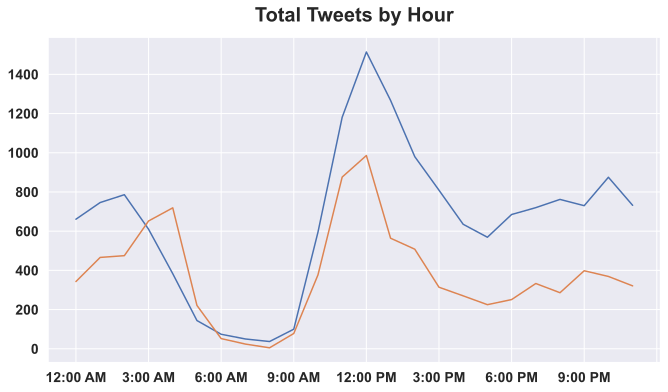

In [74]:
tweets_by_hour.index = hour_index
retweets_by_hour.index = hour_index
fig = plt.figure(figsize=(11,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
bottom = []

ax.plot(tweets_by_hour)
ax.plot(retweets_by_hour)



plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14,fontweight = 'bold')
ax.xaxis.set_major_locator(plt.MaxNLocator(9))

plt.title('Total Tweets by Hour', fontsize = 20, fontweight = 'bold', y=1.03)
plt.savefig('tweetsbyhour.png');

## Sentiment Analysis Time Series

You can skip these steps and load in the sentiment dataframe.

In [75]:
# from transformers import pipeline
# sentiment_analysis = pipeline('sentiment-analysis')

In [76]:
##this takes forever to run!
# text_sentiment = df_trump.text.apply(sentiment_analysis)
# SA_with_date = pd.DataFrame({'month_year': df_trump.month_year, 'sentiment': text_sentiment})

In [77]:
##Just load 'sentiment_month_year.csv'
# sent_anal = []
# for i in range(len(SA_with_date)):    
#     sent_anal.append(SA_with_date['sentiment'][i][0]['label'])
# SA_with_date['label'] = sent_anal
# df_SA_final = SA_with_date[['month_year', 'label']]
# def neg_finder(label):
#     if label == 'NEGATIVE':
#         return 1
#     else:
#         return 0
# def pos_finder(label):
#     if label == 'POSITIVE':
#         return 1
#     else:
#         return 0
# df_SA_final['negative'] = df_SA_final['label'].apply(neg_finder)
# df_SA_final['positive'] = df_SA_final['label'].apply(pos_finder)
# df_SA = df_SA_final.drop('label',axis = 1)
# df_SA.to_csv('sentiment_month_year.csv',index=False)

In [78]:
df_SA = pd.read_csv('sentiment_month_year.csv')
grouped_sa = df_SA.groupby('month_year').sum()
grouped_sa['total'] = grouped_sa['negative']+grouped_sa['positive'] 
grouped_sa['neg_percent'] = grouped_sa['negative']/grouped_sa['total'] 
grouped_sa['pos_percent'] = grouped_sa['positive']/grouped_sa['total'] 
grouped_ts_sa = grouped_sa.drop('2020-11', axis = 0)
grouped_ts_sa.head()

negative  positive  total  neg_percent  pos_percent
month_year                                                     
2017-01           37        35     72     0.513889     0.486111
2017-02           84        69    153     0.549020     0.450980
2017-03           67        68    135     0.496296     0.503704
2017-04           66        72    138     0.478261     0.521739
2017-05           76        68    144     0.527778     0.472222

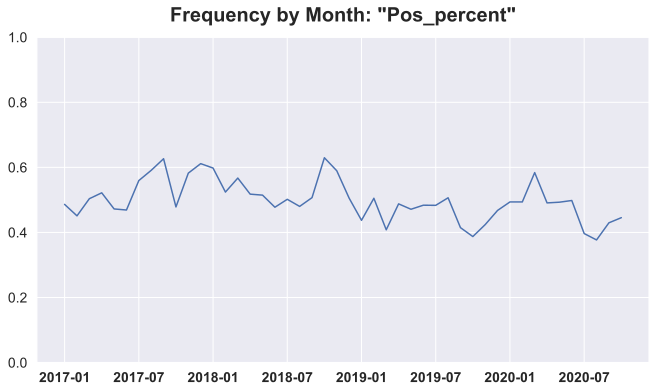

In [79]:
WordVec_to_TimeSeries_Plotter(grouped_ts_sa,'pos_percent',0,0,[0,1], 'default')

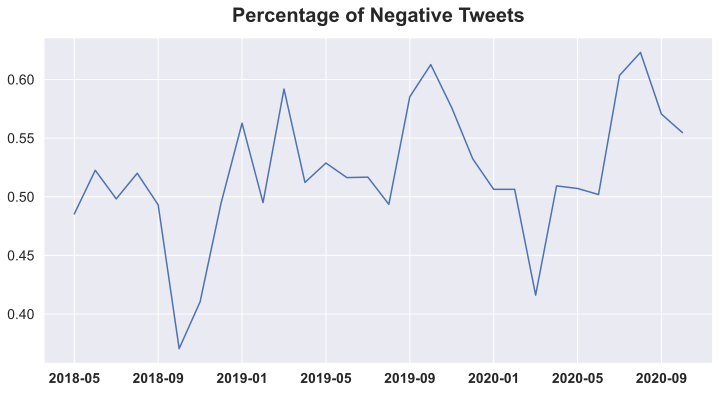

In [80]:
#We're going to make this better
#WordVec_to_TimeSeries_Plotter(grouped_ts_sa,'neg_percent',2,0,[0.3,0.7], 'default')

df = grouped_ts_sa[16:]
ts1 = df['neg_percent']
df_1 = pd.DataFrame({'Frequency': ts1.values})
df_1.index = [str(date) for date in ts1.index]

fig = plt.figure(figsize=(12,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
ax.plot(df_1['Frequency'])
#ax.plot(df_3['Frequency'], label = 'Pennsylvania')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14)
ax.set_title("Percentage of Negative Tweets",fontsize=20,fontweight = 'bold', y=1.03)


ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.savefig('neg_tweets.png');

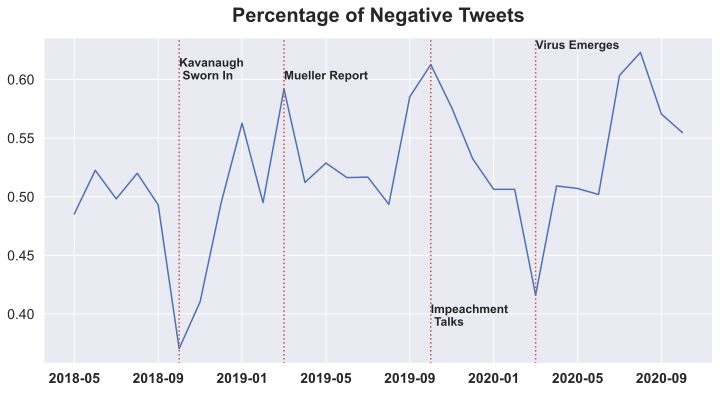

In [81]:
#We're going to make this better
#WordVec_to_TimeSeries_Plotter(grouped_ts_sa,'neg_percent',2,0,[0.3,0.7], 'default')

df = grouped_ts_sa[16:]
ts1 = df['neg_percent']
df_1 = pd.DataFrame({'Frequency': ts1.values})
df_1.index = [str(date) for date in ts1.index]

fig = plt.figure(figsize=(12,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
ax.plot(df_1['Frequency'])
#ax.plot(df_3['Frequency'], label = 'Pennsylvania')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14)
ax.set_title("Percentage of Negative Tweets",fontsize=20,fontweight = 'bold', y=1.03)
#Vertical lines
ax.axvline(x='2019-10', ymin=0, ymax=1, color = 'r', ls = ':')
plt.text('2019-10',0.39,'Impeachment \n Talks',fontweight = 'bold')
ax.axvline(x='2020-03', ymin=0, ymax=1, color = 'r', ls = ':')
plt.text('2020-03',0.626,'Virus Emerges',fontweight = 'bold')
ax.axvline(x='2018-10', ymin=0, ymax=1, color = 'r', ls = ':')
plt.text('2018-10',0.6,'Kavanaugh \n Sworn In',fontweight = 'bold')
ax.axvline(x='2019-03', ymin=0, ymax=1, color = 'r', ls = ':')
plt.text('2019-03',0.6,'Mueller Report',fontweight = 'bold')
#ax.axvline(x='2019-10', ymin=0, ymax=1, color = 'r', ls = ':')
#plt.text('2019-10',0.39,'Impeachment \n Talks',fontweight = 'bold')

ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.savefig('neg_tweets_lines.png');

In [82]:
oct_2019_mask = (df_trump['month_year'] == '2019-10')
df_oct2019 = df_trump[oct_2019_mask].text.reset_index(drop=True)
mar_2019_mask = (df_trump['month_year'] == '2019-03')
df_mar2019 = df_trump[mar_2019_mask].text.reset_index(drop=True)
oct_2018_mask = (df_trump['month_year'] =='2018-10')
df_oct2018 = df_trump[oct_2018_mask].text.reset_index(drop=True)
march_2019_mask = (df_trump['month_year'] =='2019-03')
df_mar2019 = df_trump[mar_2019_mask].text.reset_index(drop=True)


In [83]:
df_oct2019[1]

'The Greatest Witch Hunt In American History!'

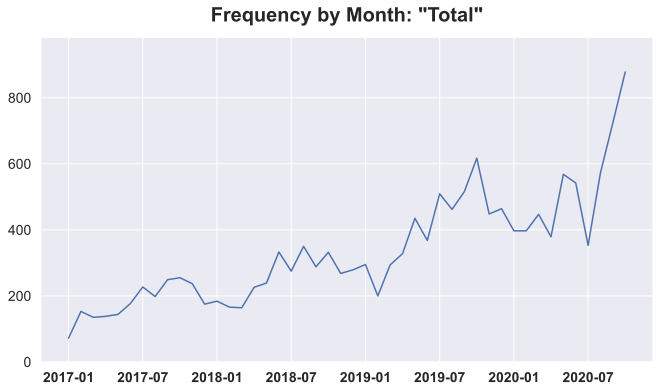

In [84]:
WordVec_to_TimeSeries_Plotter(grouped_ts_sa,'total',0,0,'default', 'default')

## Incorporating Stock Data

In [85]:
df_dow = pd.read_csv('Dow_Data_Trump.csv', header = None)
df_dow.columns = ['date','price']
df_dow['price_change'] = df_dow.price.diff()
df_dow['price_change'] = df_dow['price_change'].fillna(0)
df_dow['date'] = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in df_dow["date"]]
df_dow['year'] = pd.DatetimeIndex(df_dow['date']).year
df_dow['month_year'] = pd.to_datetime(df_dow['date']).dt.to_period('M')

In [86]:
df_dow.head()

date     price  price_change  year month_year
0 2017-01-03  19881.76          0.00  2017    2017-01
1 2017-01-04  19942.16         60.40  2017    2017-01
2 2017-01-05  19899.29        -42.87  2017    2017-01
3 2017-01-06  19963.80         64.51  2017    2017-01
4 2017-01-09  19887.38        -76.42  2017    2017-01

In [87]:
dow_month_year = df_dow[['price','month_year']]
month_mean_price = dow_month_year.groupby('month_year').mean()
dow_month_year_change = df_dow[['price_change','month_year']]
month_mean_change = dow_month_year_change.groupby('month_year').mean()

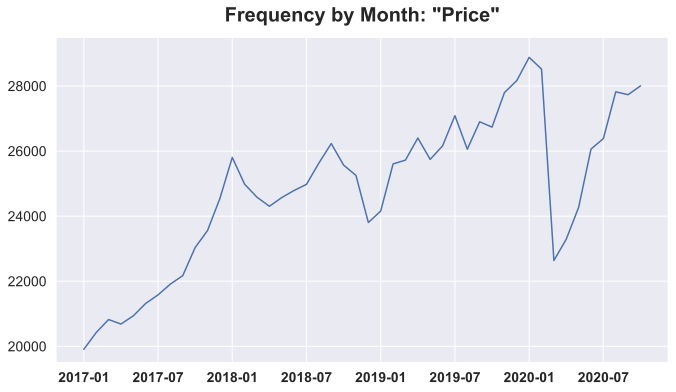

In [88]:
WordVec_to_TimeSeries_Plotter(month_mean_price,'price',0,0,[19500,29500], 'default')

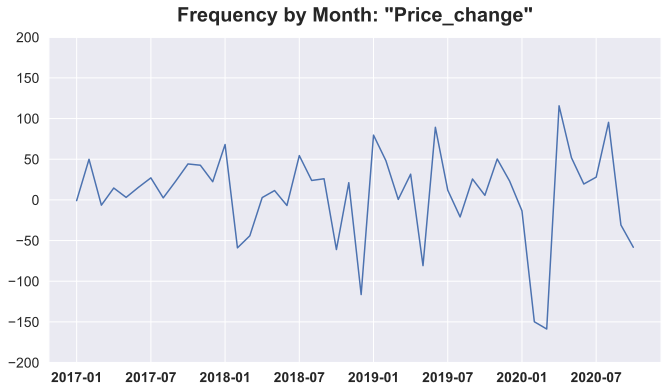

In [89]:
WordVec_to_TimeSeries_Plotter(month_mean_change,'price_change',0,0,[-200,200], 'default')

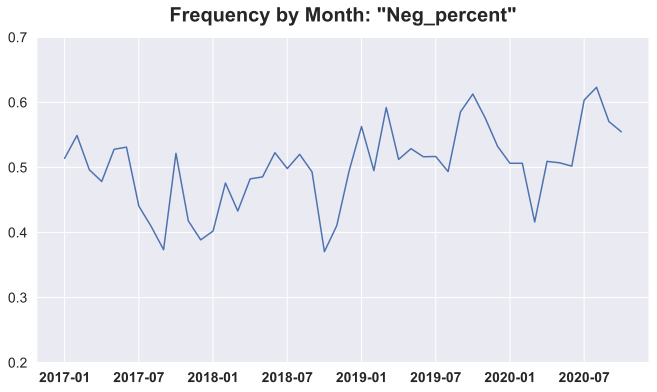

In [90]:
WordVec_to_TimeSeries_Plotter(grouped_ts_sa,'neg_percent',0,0,[0.2,0.7], 'default')

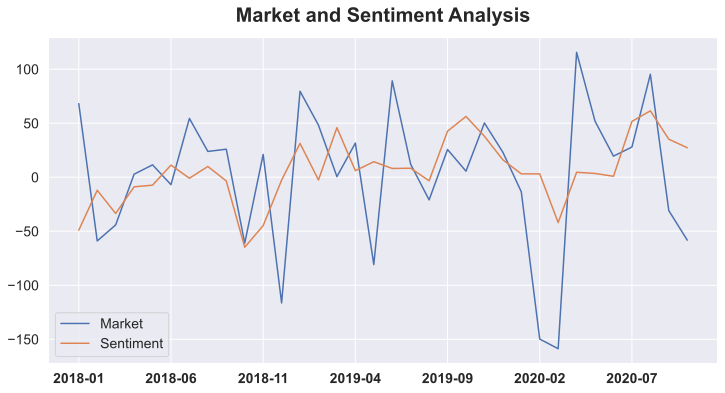

In [91]:
df1 = month_mean_change
ts1 = df1['price_change']
ts2 = grouped_ts_sa['neg_percent']
sentiment_values = 500*(ts2.values-0.5)
df_1a = pd.DataFrame({'Frequency': ts1.values})
df_2a = pd.DataFrame({'Frequency': sentiment_values})
df_1 = df_1a[12:]
df_2 = df_2a[12:]
df_1.index = [str(date) for date in ts1[12:].index]
df_2.index = [str(date) for date in ts2[12:].index]

fig = plt.figure(figsize=(12,6))
colors = ['r','darkviolet','dodgerblue','darkgreen','goldenrod','slategray']
ax = fig.add_subplot(1,1,1)
ax.plot(df_1['Frequency'], label = 'Market')
ax.plot(df_2['Frequency'], label = 'Sentiment')
plt.xticks(fontsize=14, fontweight = 'bold')
plt.yticks(fontsize=14)
ax.set_title("Market and Sentiment Analysis",fontsize=20,fontweight = 'bold', y=1.03)
#     #Vertical lines
#     for i in range(len(most_freq_months)):
#         ax.axvline(x=x_vals[i], ymin=-1, ymax=0.95, color = colors[i], 
#                     ls = ':')
#         plt.text(x_vals[i],df_ts.loc[most_freq_months[i]].Frequency * 1.05,'{}'.format(most_freq_months[i]),rotation=theta, fontweight = 'bold')
plt.legend(loc='lower left', fontsize = 14)
ax.xaxis.set_major_locator(plt.MaxNLocator(9))
plt.savefig('marketsentiment.png');